# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [15]:
from skimage.metrics import structural_similarity as ssim

In [16]:
import numpy as np
import pandas as pd

In [17]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

In [18]:
import matplotlib.pyplot as plt
import cv2 # нужно поставить себе cv2 через conda install opencv

def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

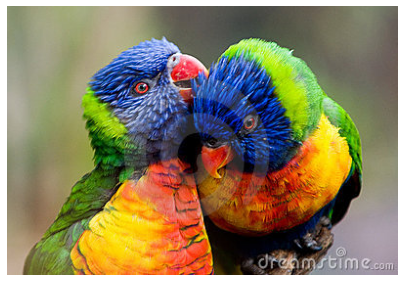

In [5]:
img = cv2.imread('/content/sample_data/ptichka.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [6]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


Начнем с KMeans:

In [7]:
w, h, _ = img.shape
res_im = img.reshape(w*h,3)

Лучший K: 20, score: 0.7593661085983151


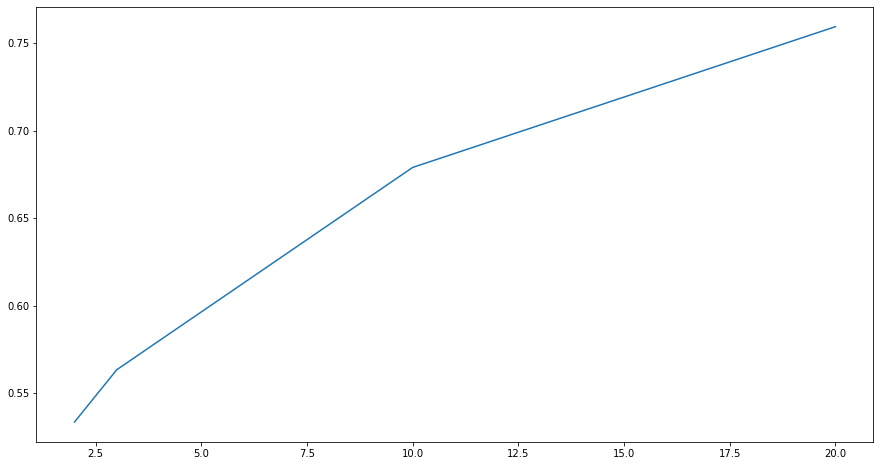

In [9]:
array_k = np.array([2, 3, 10, 20])
scores = []

for k in array_k:
  kmeans = KMeans(n_clusters=k).fit(res_im)
  labels = kmeans.predict(res_im)
  identified_palette = np.array(kmeans.cluster_centers_).astype(int)
  recolored_img = np.copy(res_im)
  for index in range(len(recolored_img)):
    recolored_img[index] = identified_palette[labels[index]]
  recolored_img = recolored_img.reshape(w,h,3)
  score = ssim(img, recolored_img, multichannel=True)
  scores.append((k, score))

best_k, max_score = max(scores, key=lambda x: x[1])
scores = np.array(scores)

print(f'Лучший K: {best_k}, score: {max_score}')

plt.figure(figsize=(15, 8))
plt.plot(array_k, scores[:, 1])
plt.show()


In [25]:
scores

array([[ 2.        ,  0.53349174],
       [ 3.        ,  0.56347096],
       [10.        ,  0.67742411],
       [20.        ,  0.75611919]])

Видно, что при увеличении количества кластеров с 10 до 20 метрика возрастает уже не так сильно.

Нарисуем изображение для 6 кластеров:

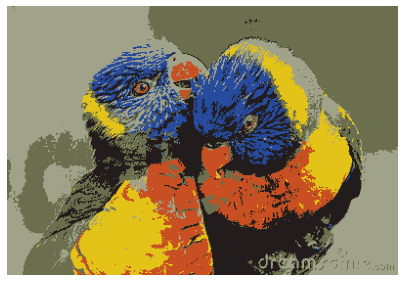

In [10]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

recolored_img = np.copy(res_im)
for index in range(len(recolored_img)):
    recolored_img[index] = identified_palette[labels[index]]
    
recolored_img = recolored_img.reshape(w,h,3)
draw_picture(recolored_img)

DBSCAN:

Тут с количеством кластеров не угадаешь, поэтому просто пробежимся по листам с eps и samples:

In [8]:
epsilons = np.arange(1, 20, 2)
samples = np.arange(20, 40, 5)
scores = []

for epsilon in epsilons:
  for n_samples in samples:
    dbscan = DBSCAN(eps=epsilon, min_samples=n_samples).fit(res_im)
    labels = dbscan.fit_predict(res_im)
    identified_palette = np.array(dbscan.components_).astype(int)
    recolored_img = np.copy(res_im)
    for index in range(len(recolored_img)):
      recolored_img[index] = identified_palette[labels[index]]
    recolored_img = recolored_img.reshape(w,h,3)
    score = ssim(img, recolored_img, multichannel=True)
    scores.append((epsilon, n_samples, score))

best_eps, best_n, max_score = max(scores, key=lambda x: x[2])
scoress = np.array(scores)

print(f'Лучший eps: {best_eps}, samples: {best_n} , score: {max_score}')


Лучший eps: 9, samples: 35 , score: 0.4162628261576407


In [9]:
scoress

array([[1.00000000e+00, 2.00000000e+01, 1.95618391e-01],
       [1.00000000e+00, 2.50000000e+01, 1.38192428e-02],
       [1.00000000e+00, 3.00000000e+01, 1.38480425e-02],
       [1.00000000e+00, 3.50000000e+01, 1.45210909e-02],
       [3.00000000e+00, 2.00000000e+01, 3.95872542e-01],
       [3.00000000e+00, 2.50000000e+01, 3.92178049e-01],
       [3.00000000e+00, 3.00000000e+01, 3.86510085e-01],
       [3.00000000e+00, 3.50000000e+01, 3.84802995e-01],
       [5.00000000e+00, 2.00000000e+01, 4.12384403e-01],
       [5.00000000e+00, 2.50000000e+01, 4.03425730e-01],
       [5.00000000e+00, 3.00000000e+01, 3.99962025e-01],
       [5.00000000e+00, 3.50000000e+01, 3.97122855e-01],
       [7.00000000e+00, 2.00000000e+01, 4.13984687e-01],
       [7.00000000e+00, 2.50000000e+01, 4.13015602e-01],
       [7.00000000e+00, 3.00000000e+01, 4.09546977e-01],
       [7.00000000e+00, 3.50000000e+01, 4.11438289e-01],
       [9.00000000e+00, 2.00000000e+01, 4.11749678e-01],
       [9.00000000e+00, 2.50000

Очень очень долго считалось для eps=[1, 10, 0.1] и samples=[20, 40, 1], поэтому перезапустил с большими шагами.

Код для отрисовки:

In [8]:
def fill_color(X, clusters, dbscan=True):
    n = max(clusters) + 1
    if dbscan:
        bias = 1
        n += 1
    else:
        bias = 0
    rsum = np.array([0]*n)
    gsum = np.array([0]*n)
    bsum = np.array([0]*n)
    count = np.array([0]*n)
    for i in range(len(X)):
        r, g, b = X[i][:]
        rsum[clusters[i]+bias] += r
        gsum[clusters[i]+bias] += g
        bsum[clusters[i]+bias] += b
        count[clusters[i]+bias] += 1
    rsum = rsum / count
    gsum = gsum / count
    bsum = bsum / count
    for i in range(len(X)):
        X[i] = [rsum[clusters[i]+bias], gsum[clusters[i]+bias], bsum[clusters[i]+bias]]
    return X

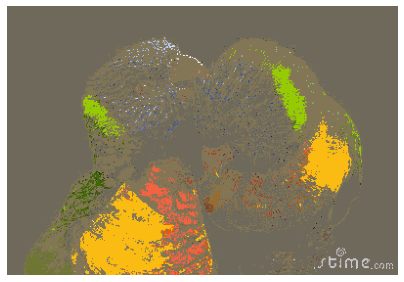

In [9]:
dbscan = DBSCAN(eps=5, min_samples=15).fit(res_im)
labels = dbscan.fit_predict(res_im)
k = pd.Series(labels).nunique()
new_img = fill_color(res_im, labels, dbscan=True).reshape((w, h, 3))
#recolored_img = recolored_img.reshape(w,h,3)
draw_picture(new_img)

Почему то при попытке перирисовать изображение, колаб сбрасывал среду выполнения - поэтому если картинку нужно перерисовать для других параметров - надо заново запустить ноутбук

Посмотрим на агломеративную кластеризацию:

In [8]:
img_for_agg = cv2.resize(img, (0,0), fx = 0.5, fy = 0.5)

In [9]:
w_a, h_a, _ = img_for_agg.shape
res_im_agg = img_for_agg.reshape(w_a*h_a,3)

Лучший K: 20, score: 0.7381817563159867


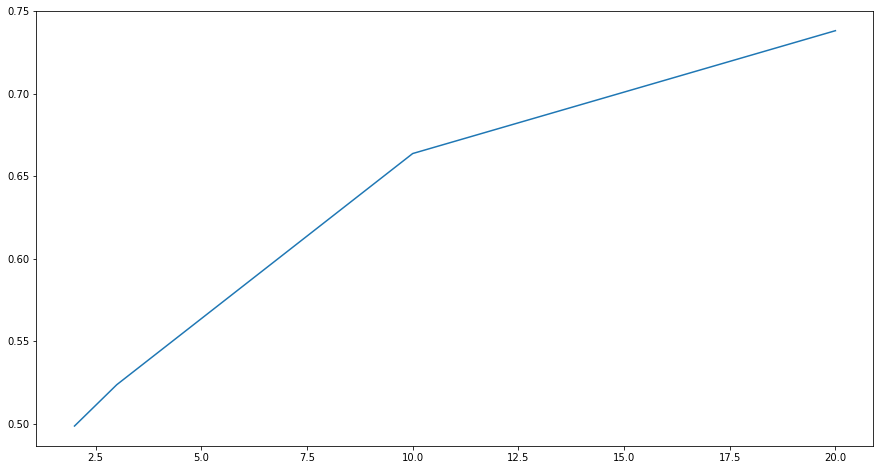

In [10]:
array_k = np.array([2, 3, 10, 20])
scores = []

for k in array_k:
  agg = AgglomerativeClustering(n_clusters=k, compute_distances=True).fit(res_im_agg)
  labels = agg.fit_predict(res_im_agg)
  clf = NearestCentroid()
  clf.fit(res_im_agg, labels)
  identified_palette = np.array(clf.centroids_).astype(int)
  recolored_img = np.copy(res_im_agg)
  for index in range(len(recolored_img)):
    recolored_img[index] = identified_palette[labels[index]]
  recolored_img = recolored_img.reshape(w_a,h_a,3)
  score = ssim(img_for_agg, recolored_img, multichannel=True)
  scores.append((k, score))

best_k, max_score = max(scores, key=lambda x: x[1])
scores = np.array(scores)

print(f'Лучший K: {best_k}, score: {max_score}')

plt.figure(figsize=(15, 8))
plt.plot(array_k, scores[:, 1])
plt.show()

In [11]:
scores

array([[ 2.        ,  0.49863699],
       [ 3.        ,  0.52367904],
       [10.        ,  0.6637424 ],
       [20.        ,  0.73818176]])

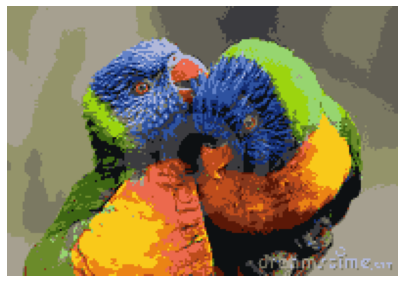

In [26]:
agg = AgglomerativeClustering(n_clusters=20, compute_distances=True).fit(res_im_agg)
labels = agg.fit_predict(res_im_agg)
clf = NearestCentroid()
clf.fit(res_im_agg, labels)
identified_palette = np.array(clf.centroids_).astype(int)
recolored_img = np.copy(res_im_agg)
for index in range(len(recolored_img)):
  recolored_img[index] = identified_palette[labels[index]]
recolored_img = recolored_img.reshape(w_a,h_a,3)
draw_picture(recolored_img)

Получился хороший результат. Dbscan отрабатывает хуже всех - возможно это связано с недостаточным количеством возможных значений параметров(для большого количества это работает оч долго). KMeans и агломеративная кластеризация, в принципе, срабатывают +- одинаково, что видно по скору.

Посмотрим, как отрабатывают KMeans и агломеративная кластеризация на наших картинках:

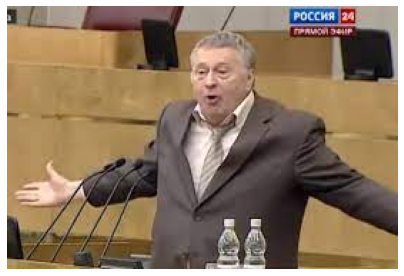

In [15]:
shirik = cv2.imread('/content/sample_data/shirik.jpg') # считать картинку
draw_picture(shirik) # нарисовать картинку

In [16]:
shirik.shape

(184, 274, 3)

In [21]:
w, h, _ = shirik.shape
res_im = shirik.reshape(w*h,3)

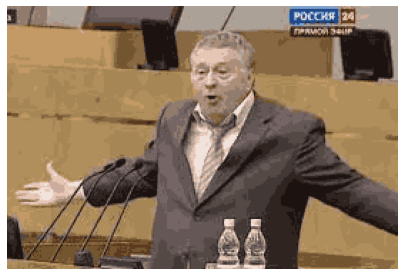

In [22]:
#Kmeans:
kmeans = KMeans(n_clusters=20, random_state=0).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

recolored_img = np.copy(res_im)
for index in range(len(recolored_img)):
    recolored_img[index] = identified_palette[labels[index]]
    
recolored_img = recolored_img.reshape(w,h,3)
draw_picture(recolored_img)

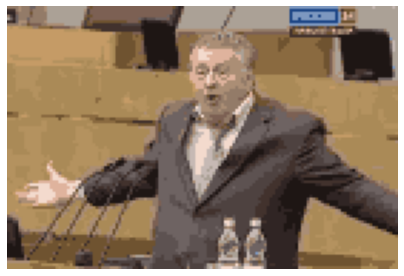

In [23]:
#Aglomerative:
img_for_agg = cv2.resize(shirik, (0,0), fx = 0.5, fy = 0.5)
w_a, h_a, _ = img_for_agg.shape
res_im_agg = img_for_agg.reshape(w_a*h_a,3)
agg = AgglomerativeClustering(n_clusters=20, compute_distances=True).fit(res_im_agg)
labels = agg.fit_predict(res_im_agg)
clf = NearestCentroid()
clf.fit(res_im_agg, labels)
identified_palette = np.array(clf.centroids_).astype(int)
recolored_img = np.copy(res_im_agg)
for index in range(len(recolored_img)):
  recolored_img[index] = identified_palette[labels[index]]
recolored_img = recolored_img.reshape(w_a,h_a,3)
draw_picture(recolored_img)

Из-за сжатия изображения получаются очень маленького разрешения.

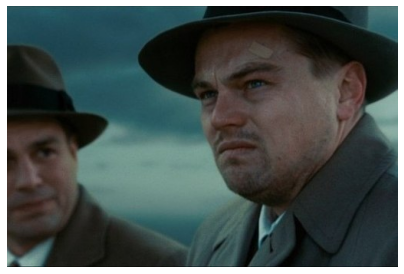

In [6]:
dicaprio = cv2.imread('/content/sample_data/dicaprio.jpg') # считать картинку
draw_picture(dicaprio)

In [7]:
dicaprio.shape

(340, 510, 3)

In [8]:
w, h, _ = dicaprio.shape
res_im = dicaprio.reshape(w*h,3)

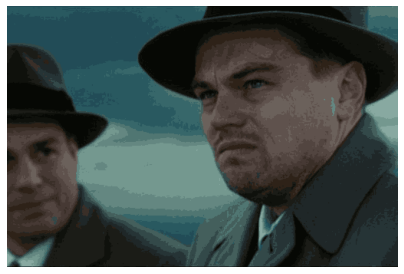

In [25]:
#Kmeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

recolored_img = np.copy(res_im)
for index in range(len(recolored_img)):
    recolored_img[index] = identified_palette[labels[index]]
    
recolored_img = recolored_img.reshape(w,h,3)
draw_picture(recolored_img)

Оч круто сработало.

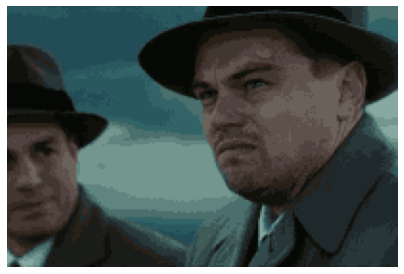

In [17]:
#Aglomerative:
img_for_agg = cv2.resize(dicaprio, (0,0), fx = 0.4, fy = 0.4)
w_a, h_a, _ = img_for_agg.shape
res_im_agg = img_for_agg.reshape(w_a*h_a,3)
agg = AgglomerativeClustering(n_clusters=20, compute_distances=True).fit(res_im_agg)
labels = agg.fit_predict(res_im_agg)
clf = NearestCentroid()
clf.fit(res_im_agg, labels)
identified_palette = np.array(clf.centroids_).astype(int)
recolored_img = np.copy(res_im_agg)
for index in range(len(recolored_img)):
  recolored_img[index] = identified_palette[labels[index]]
recolored_img = recolored_img.reshape(w_a,h_a,3)
draw_picture(recolored_img)

Визуально, на картинке с Ди Каприо агломеративная кластеризация сработала намного лучше, чем на картинке с Жириновским.

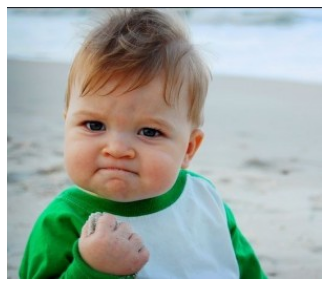

In [18]:
child = cv2.imread('/content/sample_data/child.jpg') # считать картинку
draw_picture(child)

In [19]:
child.shape

(259, 300, 3)

In [20]:
w, h, _ = child.shape
res_im = child.reshape(w*h,3)

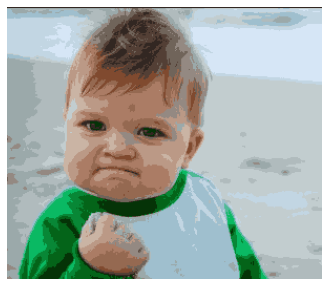

In [21]:
#Kmeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(res_im)
labels = kmeans.predict(res_im)

identified_palette = np.array(kmeans.cluster_centers_).astype(int)

recolored_img = np.copy(res_im)
for index in range(len(recolored_img)):
    recolored_img[index] = identified_palette[labels[index]]
    
recolored_img = recolored_img.reshape(w,h,3)
draw_picture(recolored_img)

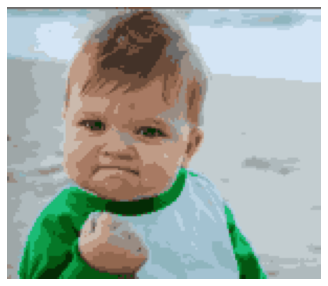

In [22]:
#Aglomerative:
img_for_agg = cv2.resize(child, (0,0), fx = 0.5, fy = 0.5)
w_a, h_a, _ = img_for_agg.shape
res_im_agg = img_for_agg.reshape(w_a*h_a,3)
agg = AgglomerativeClustering(n_clusters=20, compute_distances=True).fit(res_im_agg)
labels = agg.fit_predict(res_im_agg)
clf = NearestCentroid()
clf.fit(res_im_agg, labels)
identified_palette = np.array(clf.centroids_).astype(int)
recolored_img = np.copy(res_im_agg)
for index in range(len(recolored_img)):
  recolored_img[index] = identified_palette[labels[index]]
recolored_img = recolored_img.reshape(w_a,h_a,3)
draw_picture(recolored_img)

А на ребенке агломеративная сработала хуже.

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [2]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names
n_samples, h, w = lfw_people.images.shape

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [4]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [5]:
y.shape

(2370,)

In [6]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

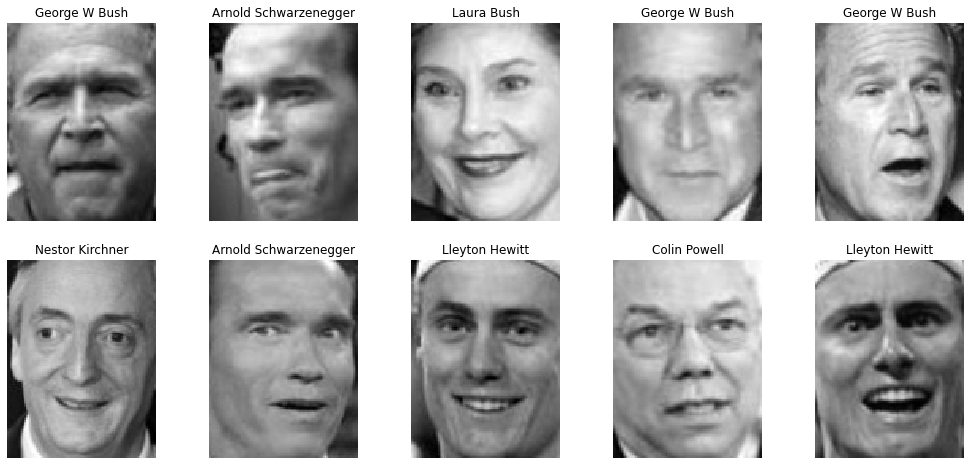

In [7]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

Начнем с логистической регрессии:

In [13]:
X_train

array([[251.66667 , 237.66667 , 214.      , ...,  43.333332,  40.333332,
         35.      ],
       [ 42.666668,  37.666668,  28.      , ...,  44.666668,  26.      ,
         27.      ],
       [ 55.333332,  55.333332,  57.666668, ...,  87.333336,  51.333332,
         47.666668],
       ...,
       [147.66667 , 143.33333 , 139.      , ...,  28.      ,  15.333333,
          9.      ],
       [ 87.333336,  97.333336, 108.333336, ..., 205.      , 204.66667 ,
        181.      ],
       [134.66667 , 118.333336, 105.      , ...,  10.333333,  19.666666,
         20.666666]], dtype=float32)

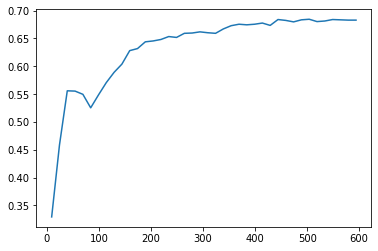

[594.           0.68301625]


In [20]:
components = np.arange(9, 600, 15)
errors = []

for n_comp in components:
  pca = PCA(n_components=n_comp)

  X_pca = pca.fit(X_train).transform(X_train)
  error = cross_val_score(LogisticRegression(), X_pca, y_train, scoring='accuracy').mean()
  errors.append((n_comp, error))

errors = np.array(errors)
best_n = max(errors, key=lambda x: x[0])
plt.plot(errors[:, 0], errors[:, 1])
plt.show()
print(best_n)

В принципе, закономерный результат - чем больше компонент, тем больше скор(понятно, что далее будет пик и падение скора при приближении к исходному количеству компонент)

Запустим модель на тесте:

In [10]:
from sklearn.metrics import accuracy_score
from collections import Counter

In [11]:
pca = PCA(n_components=594)
X_pca_train = pca.fit(X_train).transform(X_train)
X_pca_test = pca.fit(X_train).transform(X_test)

In [12]:
log = LogisticRegression()
log.fit(X_pca_train, y_train)
y_pred = log.predict(X_pca_test)

In [13]:
accuracy_score(y_test, y_pred)

0.6983122362869199

In [14]:
Counter(y_test)

Counter({0: 5,
         1: 8,
         2: 7,
         3: 18,
         4: 9,
         5: 41,
         6: 5,
         7: 29,
         8: 113,
         9: 22,
         10: 8,
         11: 6,
         12: 6,
         13: 12,
         14: 12,
         15: 10,
         16: 4,
         17: 12,
         18: 4,
         19: 17,
         20: 7,
         21: 7,
         22: 10,
         23: 10,
         24: 7,
         25: 10,
         26: 8,
         27: 4,
         28: 7,
         29: 4,
         30: 5,
         31: 34,
         32: 5,
         33: 8})

In [15]:
y_test.shape

(474,)

Можно сделать вывод о том, что наша модель намного лучше константного предсказания - максимальный accuracy при константном предсказании на test выборке равен 113/474=0.24, а для регрессии результат 0.71

Нарисуем несколько лиц(функции для отрисовки взяты с sklearn):

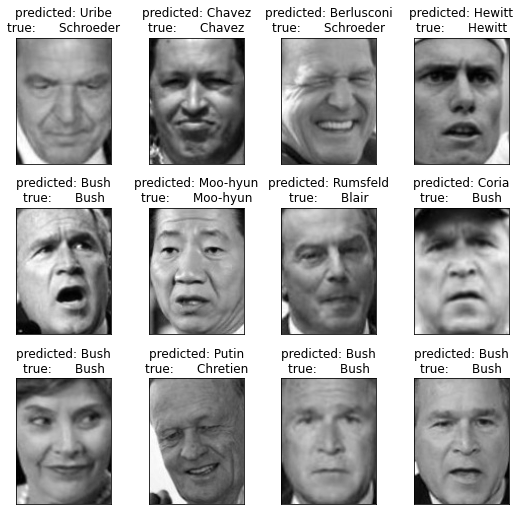

In [16]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

Визуализируем весь датасет на плоскости, используя tSNE:

In [39]:
names

array(['Alejandro Toledo', 'Alvaro Uribe', 'Andre Agassi', 'Ariel Sharon',
       'Arnold Schwarzenegger', 'Colin Powell', 'David Beckham',
       'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder',
       'Gloria Macapagal Arroyo', 'Guillermo Coria', 'Hans Blix',
       'Hugo Chavez', 'Jacques Chirac', 'Jean Chretien',
       'Jennifer Capriati', 'John Ashcroft', 'John Negroponte',
       'Junichiro Koizumi', 'Kofi Annan', 'Laura Bush', 'Lleyton Hewitt',
       'Luiz Inacio Lula da Silva', 'Megawati Sukarnoputri',
       'Nestor Kirchner', 'Recep Tayyip Erdogan', 'Roh Moo-hyun',
       'Serena Williams', 'Silvio Berlusconi', 'Tom Ridge', 'Tony Blair',
       'Vicente Fox', 'Vladimir Putin'], dtype='<U25')

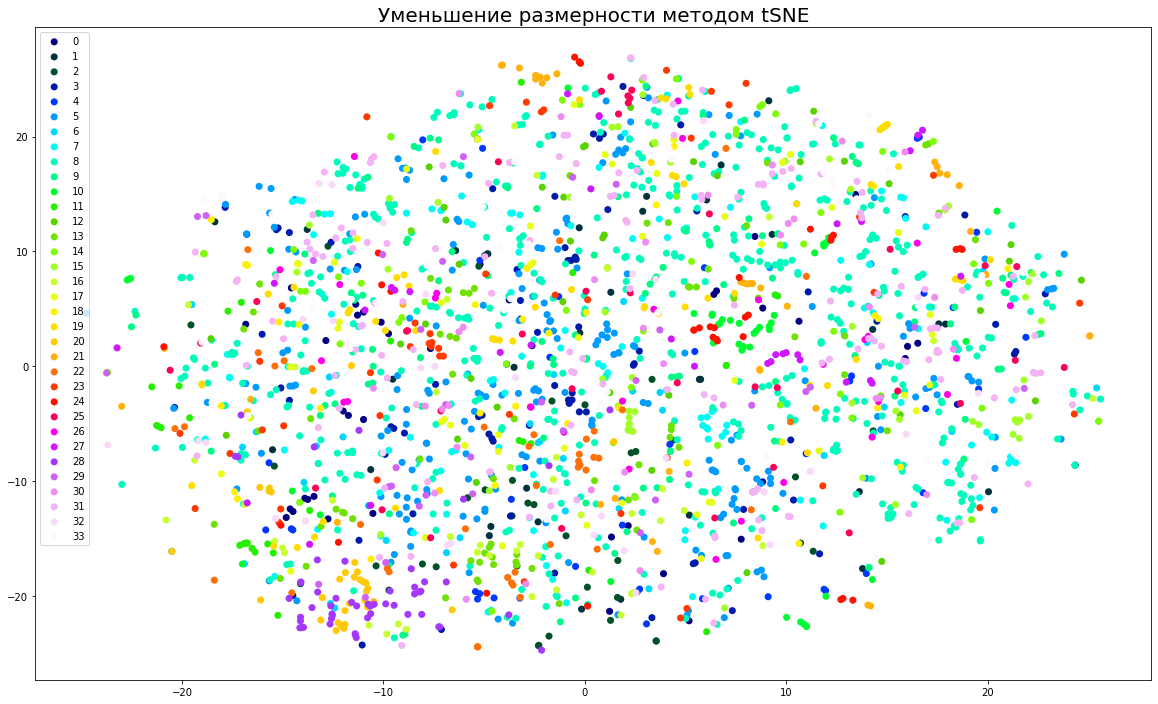

In [38]:
from matplotlib.colors import Normalize
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=400)

X_tsne_2 = tsne.fit_transform(X)
plt.figure(figsize=(20, 12))
for d in range(34):
    norm = Normalize(vmin=0, vmax=33)
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_tsne_2[:, 0][y == d],
                X_tsne_2[:, 1][y == d],
                c=[color] * len(X_tsne_2[:, 0][y == d]), label=d, edgecolor='none', s=50)
plt.title(u"Уменьшение размерности методом tSNE", fontsize=20)
plt.legend()

Непонятно и некрасиво. Посмотрим на визуализацию теста:

In [42]:
tsne = TSNE(n_components=2, random_state=42).fit(X_train)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

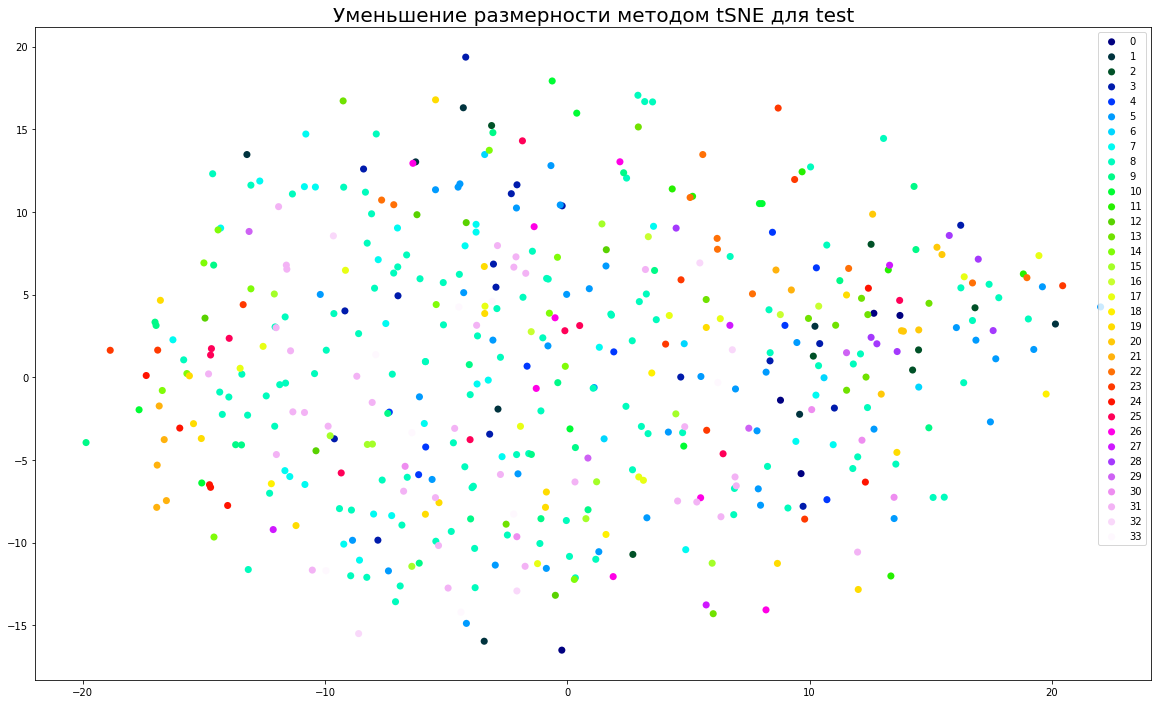

In [46]:
plt.figure(figsize=(20, 12))
for d in range(34):
    norm = Normalize(vmin=0, vmax=33)
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_test_tsne[:, 0][y_test == d],
                X_test_tsne[:, 1][y_test == d],
                c=[color] * len(X_test_tsne[:, 0][y_test == d]), label=d, edgecolor='none', s=50)
plt.title(u"Уменьшение размерности методом tSNE для test", fontsize=20)
plt.legend()

Ни на всей выборке, ни на тестовой не наблюдается какой либо упорядоченности и кластеров, в связи с чем невозможно подписать группы.

Для визуализации был выбран tSNE, так как при использовании PCA теряется несравнимо больше информации(при сжатии до двух или трех компонент). Но на этом датасете и tSNE справился не очень хорошо.

Но все же попробуем визуализировать датасет с помощью PCA:

In [17]:
pca = PCA(n_components=2, random_state=42).fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [19]:
from matplotlib.colors import Normalize

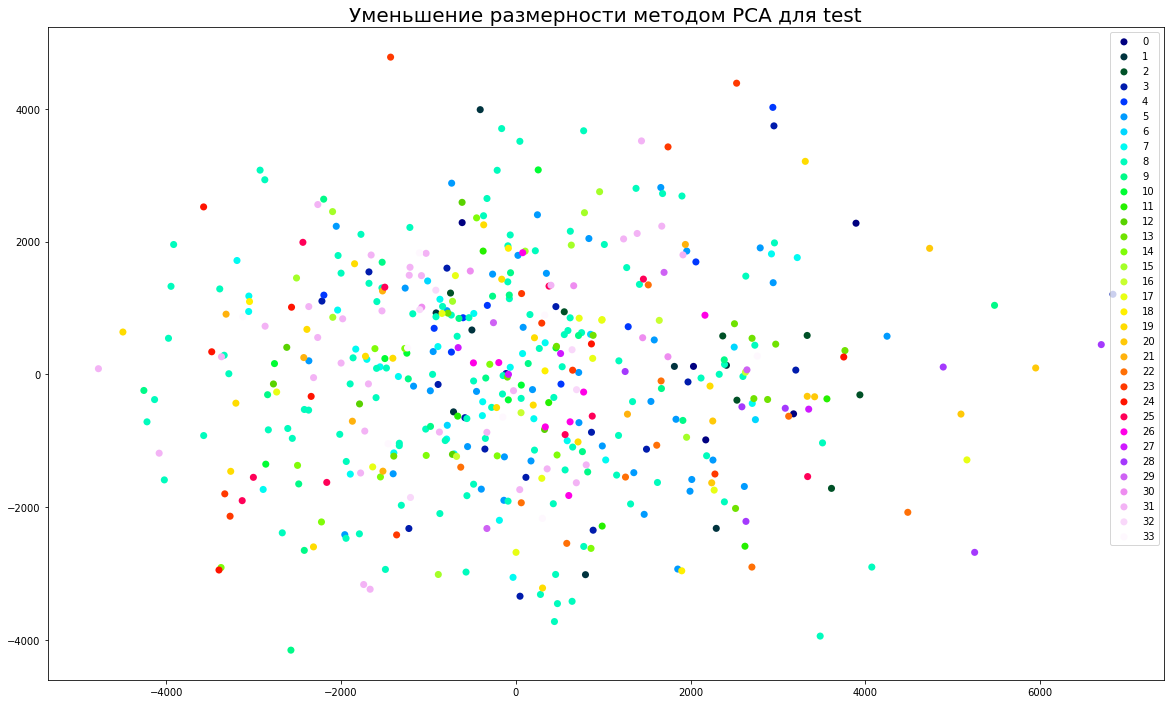

In [21]:
plt.figure(figsize=(20, 12))
for d in range(34):
    norm = Normalize(vmin=0, vmax=33)
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_test_pca[:, 0][y_test == d],
                X_test_pca[:, 1][y_test == d],
                c=[color] * len(X_test_pca[:, 0][y_test == d]), label=d, edgecolor='none', s=50)
plt.title(u"Уменьшение размерности методом PCA для test", fontsize=20)
plt.legend()

Ситуация не поменялась(

KNN здесь использовать не очень хорошо, т.к. количество признаков слишком большое.